<a href="https://colab.research.google.com/github/raphaelmendes18/kaggle-competitions/blob/master/House_Prices_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## First Working Version (30/10/2019)

Submission value: 0.18653

## To do (31/10/2019)

* ~~Apply Transformation in SalePrice~~ 
* ~~Apply Box Cox Transformation in high Skewness~~
* ~~Leave Highly Correlated Variables in Training~~

## To do Plus

* Apply Averaged Models
* Apply More Advanced Techniques based on Kernel: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

##### Author: Raphael L Mendes - raphael.mendes@ufu.br



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
# Preprocessing
df_train = pd.read_csv('/content/drive/My Drive/kaggle/house_prices/train.csv')
## Remove Columns with more than 50% NaN
cols_to_remove_nan = [c for c in df_train.columns if df_train[c].isnull().sum()/df_train.shape[0] > 0.50]

## Remove Columns with too many zeroes
cols_to_remove_zeroes = [c for c in df_train.columns if df_train[df_train[c]==0].shape[0]/df_train.shape[0] > 0.75]

cols_to_remove = cols_to_remove_nan + cols_to_remove_zeroes

cols_to_keep = [c for c in df_train.columns if c not in (cols_to_remove)]

## Select Numeric Columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_train_numerics = df_train[cols_to_keep].select_dtypes(include=numerics)

## Identify Correlations
data = df_train_numerics
## generate correlation matrix
corr = data.corr()

# Will use this to remove the less correlated feature between each pair of highly correlated features to be found later on
target_correlation = corr['SalePrice'].sort_values(ascending=False)

## Ideas for Feature Engineering
# Age = YearSold - YearBuilt 
# df_train_numerics['Age'] = df_train_numerics['YrSold'] - df_train_numerics['YearBuilt']

data = df_train_numerics
## generate correlation matrix
corr = data.corr()

high_correlated_features = []
remove_columns_correlation = []
for c in df_train_numerics.columns:
    indexes = corr[corr[c] > 0.8].index
    for i in indexes:
        if i != c:
            high_correlated_features.append((i,c))

for feat1, feat2 in high_correlated_features:
    if corr.loc[feat1,'SalePrice'] > corr.loc[feat2,'SalePrice']:
        if(feat2 not in remove_columns_correlation):
            remove_columns_correlation.append(feat2)
    else:
        if(feat1 not in remove_columns_correlation):
            remove_columns_correlation.append(feat1)

## Update list of columns to Remove
cols_to_remove += remove_columns_correlation
## Update list of columns to Keep
cols_to_keep = [c for c in df_train.columns if c not in (cols_to_remove)]

## Select Categorical Columns
df_train_categorical = df_train[cols_to_keep].select_dtypes(include=['object'])

## Find columns with too many categories
size = df_train_categorical.shape[1]
columns = df_train_categorical.apply(lambda x: len(x.unique())).sort_values(ascending=False)[0:size].index

## Investigate
# fig, axs = plt.subplots(size, 1, figsize=(15, size*10))
# fig_idx = 0
# for c in columns:
#     box_plot_data = [df_train.loc[df_train[c]==val,'SalePrice'].values for val in df_train[c].unique() ]
#     axs[fig_idx].boxplot(box_plot_data,vert=0, labels=df_train[c].unique())
#     axs[fig_idx].set_title(c)
#     fig_idx += 1

# plt.show()

# Column Utilities should be removed, only has one value
cols_to_remove += ['Utilities']
cols_to_keep = [c for c in df_train.columns if c not in cols_to_remove]

## Take care of NAs

df_train.loc[df_train['Fireplaces']==0,'FireplaceQu'] = 'No'
df_train['LotFrontage'] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df_train[['GarageCond','GarageType','GarageFinish','GarageQual']] = df_train[['GarageCond','GarageType','GarageFinish','GarageQual']].fillna('No')
df_train[['BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual']] = df_train[['BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual']].fillna('No')
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('No')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

cols_to_keep += ['TotalSF']

In [0]:
### Data Transformations

df_train = df_train[cols_to_keep]
y = df_train['SalePrice']
df_train.drop(columns={'SalePrice','Id'},inplace=True)

numerics_df = df_train.select_dtypes(include=numerics)
categorical = df_train.select_dtypes(include=['object'])

## Identify Numerical Categorical Columns

categorical_numerical = numerics_df.apply(lambda x: len(x.unique())).sort_values(ascending=False)
categorical_numerical = categorical_numerical[categorical_numerical <=15][:].index
categorical_numerical = [val for val in categorical_numerical if val not in ['BedroomAbvGr','KitchenAbvGr','GarageCars','BsmtFullBath','FullBath','Fireplaces']]


## Get Dummies for Categorical Columns

all_categorical = np.concatenate([categorical.columns,categorical_numerical])
df_train[categorical_numerical] = df_train[categorical_numerical].astype(str)
df_transformed = pd.get_dummies(df_train[all_categorical],drop_first=True)
df_transformed['MSSubClass_150'] = 0
numerics_df = df_train.select_dtypes(include=numerics) 

## Scale Numerical Columns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()
# ss = MinMaxScaler()
ss.fit(numerics_df)

df_numeric_transformed = ss.transform(numerics_df)

final_train = np.column_stack((df_numeric_transformed,df_transformed.values))

In [0]:
## Test Data
cols_to_keep = [c for c in cols_to_keep if c!='SalePrice']
df_test = pd.read_csv('/content/drive/My Drive/kaggle/house_prices/test.csv')

## New Feature
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

df_test = df_test[cols_to_keep]
df_test.drop(columns={'Id'},inplace=True)

## Adjust NaN
df_test.loc[df_test['Fireplaces']==0,'FireplaceQu'] = 'No'
df_test['LotFrontage'] = df_test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df_test[['GarageCond','GarageType','GarageFinish','GarageQual']] = df_test[['GarageCond','GarageType','GarageFinish','GarageQual']].fillna('No')
df_test[['BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual']] = df_test[['BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual']].fillna('No')
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('No')
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)



df_test[categorical_numerical] = df_test[categorical_numerical].fillna(0)

# df_test[cols_to_keep].select_dtypes(include=numerics) = df_test[cols_to_keep].select_dtypes(include=numerics).fillna(0)
df_test[categorical_numerical] = df_test[categorical_numerical].astype(str)
df_test_transformed = pd.get_dummies(df_test[all_categorical],drop_first=True)

numerics_test_df = df_test.select_dtypes(include=numerics)
numerics_test_df = numerics_test_df.fillna(0)

df_numeric_test_transformed = ss.transform(numerics_test_df)

## Fixing missing columns in get_dummies
for c in df_transformed.columns:
    if c not in df_test_transformed.columns:
        df_test_transformed[c] = 0

final_test = np.column_stack((df_numeric_test_transformed,df_test_transformed.values))

In [0]:
### Select Models

from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error,mean_squared_error
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmlse'},
    'num_leaves': 60,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

n_estimators = 100

rfr = RandomForestRegressor(n_estimators = 100)
# mlr = MLPRegressor(hidden_layer_sizes=(30, 3),max_iter=1000)
X = np.nan_to_num(final_train)
kf = KFold(n_splits=10,shuffle=True, random_state=2)
kf.get_n_splits(X)
fold = 0
results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_test, label=y_test)
    watchlist = [d_valid]

    lgb_model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)
    rfr.fit(X_train, y_train)
    # mlr.fit(X_train, y_train)

    rfr_y_pred = rfr.predict(X_test)
    # mlr_y_pred = mlr.predict(X_test)
    lgbm_y_pred = lgb_model.predict(X_test)

    fold += 1
    print('Random Forest Regressor')
    print('FOLD: {} - RMLSE: {}'.format(fold,np.sqrt(mean_squared_log_error( y_test, rfr_y_pred ))))
    print('LGBM Regressor')
    print('FOLD: {} - RMLSE: {}'.format(fold,np.sqrt(mean_squared_log_error( y_test, lgbm_y_pred ))))
    results.append([np.sqrt(mean_squared_log_error( y_test, rfr_y_pred )),np.sqrt(mean_squared_log_error( y_test, lgbm_y_pred ))])
# print('Mean: {} std: {}'.format(np.mean(results), np.std(results)))

'''
FOLD: 1 - RMSE: 33447.7470221955
FOLD: 2 - RMSE: 26461.84551420078
FOLD: 3 - RMSE: 47848.611452681704
FOLD: 4 - RMSE: 23193.730215083506
FOLD: 5 - RMSE: 35547.480546581515
FOLD: 6 - RMSE: 27351.656316595305
FOLD: 7 - RMSE: 23910.190923121834
FOLD: 8 - RMSE: 22770.093361547337
FOLD: 9 - RMSE: 31718.23580741277
FOLD: 10 - RMSE: 20708.2812451745
MEAN: 29324.40
STD:7541.17
'''

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline


# def root_mean_squared_log_error(y_true, y_pred):
#         return np.sqrt(mean_squared_log_error( y_true, y_pred ))

# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))       

# # define base model
# def baseline_model():
# 	# create model
#     model = Sequential()
#     model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
#     model.add(Dense(32, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     model.compile(loss=root_mean_squared_error, optimizer='adam')
#     return model

# estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=8, verbose=True)
# kfold = KFold(n_splits=2)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Baseline: %.2f (%.2f) RMSE" % (results.mean(), results.std()))


Random Forest Regressor
FOLD: 1 - RMLSE: 0.14905008283820145
LGBM Regressor
FOLD: 1 - RMLSE: 0.14085382256757198
Random Forest Regressor
FOLD: 2 - RMLSE: 0.1641639872698573
LGBM Regressor
FOLD: 2 - RMLSE: 0.15416287976073217
Random Forest Regressor
FOLD: 3 - RMLSE: 0.18836927080579735
LGBM Regressor
FOLD: 3 - RMLSE: 0.16999715906089743
Random Forest Regressor
FOLD: 4 - RMLSE: 0.14505146244123396
LGBM Regressor
FOLD: 4 - RMLSE: 0.13229077363229205
Random Forest Regressor
FOLD: 5 - RMLSE: 0.1320268411260973
LGBM Regressor
FOLD: 5 - RMLSE: 0.12545310498614246
Random Forest Regressor
FOLD: 6 - RMLSE: 0.16291558545048554
LGBM Regressor
FOLD: 6 - RMLSE: 0.14564808489922568
Random Forest Regressor
FOLD: 7 - RMLSE: 0.14515573954989372
LGBM Regressor
FOLD: 7 - RMLSE: 0.13490961091652975
Random Forest Regressor
FOLD: 8 - RMLSE: 0.13704605598541506
LGBM Regressor
FOLD: 8 - RMLSE: 0.13982482779855962
Random Forest Regressor
FOLD: 9 - RMLSE: 0.1477707285448784
LGBM Regressor
FOLD: 9 - RMLSE: 0.1335

'\nFOLD: 1 - RMSE: 33447.7470221955\nFOLD: 2 - RMSE: 26461.84551420078\nFOLD: 3 - RMSE: 47848.611452681704\nFOLD: 4 - RMSE: 23193.730215083506\nFOLD: 5 - RMSE: 35547.480546581515\nFOLD: 6 - RMSE: 27351.656316595305\nFOLD: 7 - RMSE: 23910.190923121834\nFOLD: 8 - RMSE: 22770.093361547337\nFOLD: 9 - RMSE: 31718.23580741277\nFOLD: 10 - RMSE: 20708.2812451745\nMEAN: 29324.40\nSTD:7541.17\n'

In [0]:
d_x = lgb.Dataset(X, label=y)
lgb_model = lgb.train(params, d_x, n_estimators, verbose_eval=1)
rfr.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
lgbm_pred = lgb_model.predict(final_test)
rfr_pred = rfr.predict(final_test)

In [0]:
lgbm_df = pd.DataFrame(lgbm_pred,columns=['SalePrice'])
lgbm_df.index += 1461
lgbm_df.reset_index(inplace=True)
lgbm_df.rename(columns={'index':'Id'},inplace=True)
rfr_df = pd.DataFrame(rfr_pred,columns=['SalePrice'])
rfr_df.index += 1461
rfr_df.reset_index(inplace=True)
rfr_df.rename(columns={'index':'Id'},inplace=True)
lgbm_df.to_csv('/content/drive/My Drive/kaggle/house_prices/lgbm_output.csv',index=False)
rfr_df.to_csv('/content/drive/My Drive/kaggle/house_prices/rfr_output.csv',index=False)



### Submission #2


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_train = pd.read_csv('/content/drive/My Drive/kaggle/house_prices/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/kaggle/house_prices/test.csv')

train_ID = df_train['Id']
test_ID = df_test['Id']

y = np.log1p(df_train['SalePrice']).values
df_train.drop(columns={'SalePrice'}, inplace=True)

all_data = pd.concat([df_train,df_test],sort=False)
all_data.drop(columns={'Id'}, inplace=True)

## remove Missing Values

missing_data = all_data.apply(lambda x: (x.isnull().sum()/len(x))*100).sort_values(ascending=False)

missing_data = missing_data[missing_data > 0]

fill_none = ['PoolQC','MiscFeature','Alley','Fence','GarageCond','GarageQual','GarageFinish','GarageType','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2','MasVnrType','KitchenQual','FireplaceQu','BsmtCond']
for c in fill_none:
    all_data[c] = all_data[c].fillna('None')

fill_zeroes = ['GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtHalfBath','BsmtFullBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']

for c in fill_zeroes:
    all_data[c] = all_data[c].fillna(0)

fill_mode = ['Utilities','MSZoning','SaleType','Electrical','Exterior1st','Exterior2nd']

for c in fill_mode:
    all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

## Other Columns
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data.drop(columns={'Utilities'},inplace=True)
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### Create categorical columns

#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

categorical = all_data.select_dtypes(include='object').columns
numerical = all_data.select_dtypes(exclude='object').columns

from scipy.special import boxcox1p
from scipy.stats import skew

skewed_feats = all_data[numerical].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

all_data = pd.get_dummies(all_data)

train = all_data[:len(train_ID)].values
test = all_data[len(train_ID):].values


In [122]:
### Select Models

from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error,mean_squared_error
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmlse'},
    'num_leaves': 60,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

n_estimators = 100

rfr = RandomForestRegressor(n_estimators = 250)
# mlr = MLPRegressor(hidden_layer_sizes=(30, 3),max_iter=1000)
X = np.nan_to_num(train)
kf = KFold(n_splits=10,shuffle=True, random_state=2)
kf.get_n_splits(X)
fold = 0
results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_test, label=y_test)
    watchlist = [d_valid]

    lgb_model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)
    rfr.fit(X_train, y_train)
    # mlr.fit(X_train, y_train)

    rfr_y_pred = rfr.predict(X_test)
    # mlr_y_pred = mlr.predict(X_test)
    lgbm_y_pred = lgb_model.predict(X_test)

    fold += 1
    print('Random Forest Regressor')
    print('FOLD: {} - RMLSE: {}'.format(fold,np.sqrt(mean_squared_log_error( y_test, rfr_y_pred ))))
    print('LGBM Regressor')
    print('FOLD: {} - RMLSE: {}'.format(fold,np.sqrt(mean_squared_log_error( y_test, lgbm_y_pred ))))
    print('Combined')
    print('FOLD: {} - RMLSE: {}'.format(fold,np.sqrt(mean_squared_log_error( y_test, 0.75*lgbm_y_pred + 0.25*rfr_y_pred ))))

Random Forest Regressor
FOLD: 1 - RMLSE: 0.01052699216352836
LGBM Regressor
FOLD: 1 - RMLSE: 0.009385668989981742
Combined
FOLD: 1 - RMLSE: 0.009523314198435657
Random Forest Regressor
FOLD: 2 - RMLSE: 0.012310427724853325
LGBM Regressor
FOLD: 2 - RMLSE: 0.010937071260982166
Combined
FOLD: 2 - RMLSE: 0.011160296511907345
Random Forest Regressor
FOLD: 3 - RMLSE: 0.013837271281225715
LGBM Regressor
FOLD: 3 - RMLSE: 0.012695613215337792
Combined
FOLD: 3 - RMLSE: 0.012892727069073438
Random Forest Regressor
FOLD: 4 - RMLSE: 0.010351972566835675
LGBM Regressor
FOLD: 4 - RMLSE: 0.010040818458290631
Combined
FOLD: 4 - RMLSE: 0.009936583246730095
Random Forest Regressor
FOLD: 5 - RMLSE: 0.010085669490461642
LGBM Regressor
FOLD: 5 - RMLSE: 0.009339454533708135
Combined
FOLD: 5 - RMLSE: 0.009340094930923548
Random Forest Regressor
FOLD: 6 - RMLSE: 0.011520726982929537
LGBM Regressor
FOLD: 6 - RMLSE: 0.010699690136105127
Combined
FOLD: 6 - RMLSE: 0.010776625862532453
Random Forest Regressor
FOLD:

In [109]:
d_x = lgb.Dataset(X, label=y)
lgb_model = lgb.train(params, d_x, n_estimators, verbose_eval=1)
rfr.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
# lgbm_pred = np.expm1(lgb_model.predict(test))
# rfr_pred = np.expm1(rfr.predict(test))
combined_pred = 0.75*lgbm_pred + 0.25*rfr_pred

In [0]:
lgbm_df = pd.DataFrame(lgbm_pred,columns=['SalePrice'])
lgbm_df.index += 1461
lgbm_df.reset_index(inplace=True)
lgbm_df.rename(columns={'index':'Id'},inplace=True)
rfr_df = pd.DataFrame(rfr_pred,columns=['SalePrice'])
rfr_df.index += 1461
rfr_df.reset_index(inplace=True)
rfr_df.rename(columns={'index':'Id'},inplace=True)
combined_df = pd.DataFrame(combined_pred,columns=['SalePrice'])
combined_df.index += 1461
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index':'Id'},inplace=True)


# lgbm_df.to_csv('/content/drive/My Drive/kaggle/house_prices/lgbm_output_v2.csv',index=False)
# rfr_df.to_csv('/content/drive/My Drive/kaggle/house_prices/rfr_output_v2.csv',index=False)
combined_df.to_csv('/content/drive/My Drive/kaggle/house_prices/combined_output_v2.csv',index=False)


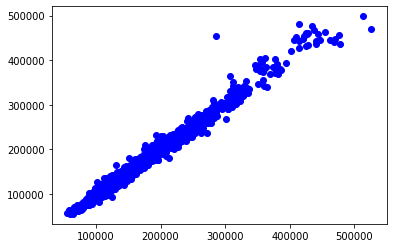

In [121]:
plt.scatter(rfr_pred,lgbm_pred,c='blue')
# plt.scatter(rfr_pred,rfr_pred,c='green')
